In [2]:
pip install mlflow scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 61.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Load dataset
df = pd.read_csv('/kaggle/input/loan-default/Loan_default.csv')

# Display column names and types
print(df.info())

# Display summary statistics
print(df.describe())

# Encode categorical variables using one-hot encoding
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 
                       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
X_encoded = pd.get_dummies(df.drop(['LoanID', 'Default'], axis=1), columns=categorical_columns, drop_first=True)

# Split data into input features (X) and target variable (y)
X = X_encoded
y = df['Default']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# Define parameter distributions for randomized search
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20)
}

# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV for hyperparameter tuning with reduced settings
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV on scaled training data
random_search.fit(X_train_scaled, y_train)

# Get best hyperparameters and model
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate best model on test data
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (after hyperparameter tuning): {accuracy:.2f}")


from sklearn.model_selection import cross_val_score

# cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")


import matplotlib.pyplot as plt
# Get feature importances from the best model
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


import mlflow
import mlflow.sklearn

# Log parameters and metrics to MLflow
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_params(best_model.get_params())
    
    # Log metrics
    mlflow.log_metric('accuracy', accuracy)
    
    # Log model
    mlflow.sklearn.log_model(best_model, 'random_forest_model')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [4]:
from sklearn.model_selection import cross_val_score

# cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")


Cross-Validation Scores: [0.88503902 0.88514559]
Mean CV Accuracy: 0.89 (+/- 0.00)


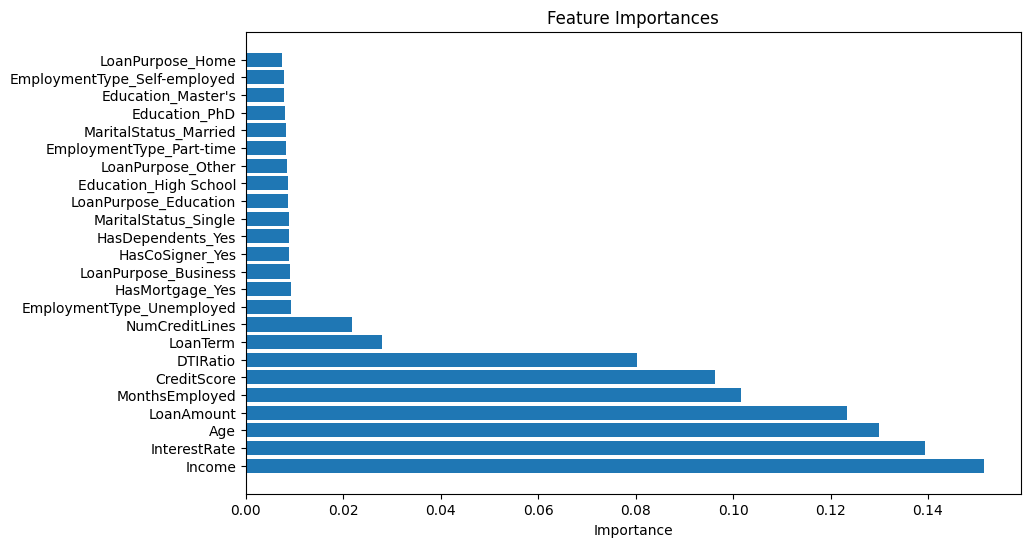

In [5]:
import matplotlib.pyplot as plt
# Get feature importances from the best model
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [6]:
import mlflow
import mlflow.sklearn

# Log parameters and metrics to MLflow
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_params(best_model.get_params())
    
    # Log metrics
    mlflow.log_metric('accuracy', accuracy)
    
    # Log model
    mlflow.sklearn.log_model(best_model, 'random_forest_model')



In [8]:
import mlflow
import mlflow.sklearn

# Set the MLflow tracking URI to a local directory
#mlflow.set_tracking_uri("file:///path/to/mlflow")

# Create or get an MLflow experiment
mlflow.set_experiment("loan_default_prediction")

# Load dataset
df = pd.read_csv('/kaggle/input/loan-default/Loan_default.csv')

# Preprocessing, model training, and evaluation code...

# Log parameters and metrics to MLflow
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_params(best_model.get_params())
    
    # Log metrics
    mlflow.log_metric('accuracy', accuracy)
    
    # Log model
    mlflow.sklearn.log_model(best_model, 'random_forest_model')


/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
